In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta


In [35]:
# Using Russell Index
data = yf.download(tickers = '^RUI', start = '2012-03-11', end = '2024-08-01', interval = '1d')

[*********************100%%**********************]  1 of 1 completed


In [36]:
#Implement Indicators: RSI and 20, 100, 150 day EMA
data['RSI'] = ta.rsi(data['Close'], length = 15)
data['EMA20'] = ta.ema(data['Close'], length = 20)
data['EMA100'] = ta.ema(data['Close'], length = 100)
data['EMA150'] = ta.ema(data['Close'], length = 150)

#Prediction target: Closing price of the following day 
data['Target'] = data['Adj Close'].shift(-1) 

#Clean
data.dropna(inplace = True)
data.reset_index(inplace = True)
data.drop(columns = ['Volume', 'Close', 'Date'], axis = 1, inplace = True)


,Open,High,Low,Adj Close,RSI,EMA20,EMA100,EMA150,Target
0,791.440002,795.679993,789.760010,789.760010,46.877256,795.406526,775.179523,762.677734,787.179993
1,789.869995,792.669983,785.640015,787.179993,44.575540,794.623046,775.417156,763.002267,793.440002
2,787.179993,794.020020,786.260010,793.440002,50.849388,794.510376,775.774044,763.405416,801.599976
3,794.580017,801.859985,794.580017,801.599976,57.558969,795.185576,776.285448,763.911304,805.039978
4,800.669983,805.770020,800.669983,805.039978,60.023875,796.124090,776.854845,764.456055,803.330017
...,...,...,...,...,...,...,...,...,...
2961,3013.050049,3013.050049,2957.689941,2960.320068,42.932870,3013.637561,2887.138729,2818.541729,2948.679932
2962,2961.979980,2998.290039,2942.530029,2948.679932,41.189298,3007.451120,2888.357366,2820.265414,2982.139893
2963,2963.229980,2997.169922,2963.229980,2982.139893,47.727439,3005.040527,2890.214446,2822.409447,2984.219971
2964,2991.469971,2997.620117,2974.389893,2984.219971,48.111663,3003.057617,2892.075941,2824.552633,2970.770020


In [5]:
from sklearn.preprocessing import MinMaxScaler #Scale data as probabilities between 0 and 1
sc = MinMaxScaler(feature_range=(0,1)) 
scaled_data = sc.fit_transform(data)
print(scaled_data)

[[1.88632234e-02 1.88184437e-02 2.02982689e-02 ... 7.53957271e-05
  0.00000000e+00 1.69437180e-02]
 [1.81890735e-02 1.75328399e-02 1.85317137e-02 ... 1.87560104e-04
  1.57249448e-04 1.96141087e-02]
 [1.70340058e-02 1.81094534e-02 1.87975528e-02 ... 3.56013620e-04
  3.52591320e-04 2.30949845e-02]
 ...
 [9.51414244e-01 9.59095714e-01 9.52230100e-01 ... 9.98385835e-01
  9.98023153e-01 9.54155533e-01]
 [9.63540293e-01 9.59287997e-01 9.57015203e-01 ... 9.99264473e-01
  9.99061613e-01 9.48418062e-01]
 [9.63583275e-01 9.59659528e-01 9.47517855e-01 ... 1.00000000e+00
  1.00000000e+00 9.67490407e-01]]


In [6]:
X = [] #Predictors array
back_days = 10
for i in range(8):
    X.append([])
    for j in range(back_days, scaled_data.shape[0]):
        X[i].append(scaled_data[j-back_days:j, i])

X = np.array(X)
y = np.reshape(np.array(scaled_data[back_days:, -1]), (X.shape[1], 1))
X = np.moveaxis(X, [0], [2])


In [7]:
#Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [11]:
#Keras Implementation of LSTM model
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Activation, concatenate

lstm_input = Input(shape=(back_days, 8) , name='lstm_input') #8 indicators
inputs = LSTM(150, name='First')(lstm_input) #150 neurons in the first layer
inputs = Dense(1, name='Dense')(inputs) #Output layer
output = Activation('linear', name='Output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam() #Optimizer
model.compile(optimizer = adam, loss = 'mse')
model.fit(x = X_train, y = y_train, batch_size = 15, epochs = 30, validation_split = 0.2) #Train model

Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0050 - val_loss: 3.0645e-04
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2275e-04 - val_loss: 0.0016
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.8697e-05 - val_loss: 0.0020
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3145e-04 - val_loss: 3.3110e-04
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1607e-04 - val_loss: 0.0022
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2983e-04 - val_loss: 3.4949e-04
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0304e-04 - val_loss: 2.6535e-04
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1989e-04 - val_loss: 0.0012
Epoch 9/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0163e-04 - val_loss: 3.4073e-04
Epoch 10/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4626e-04 - val_loss: 0.0013
Epoch 11/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3126e-05 - val_loss:

In [ ]:
y_pred = model.predict(X_test) #Predict closing price of the following day

#Plot results
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'red', label = 'Real Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Price')
plt.legend()
plt.show()


In [16]:
#Rough PyTorch Implementation of LSTM model
import torch 
import torch.nn as nn   
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.dense = nn.Linear(hidden_size, output_size)
        self.activation = nn.Linear(output_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        dense_out = self.dense(lstm_out[:, -1, :]) #Output of the last time step
        output = self.activation(dense_out)
        return output


In [43]:
input_size = 8 #8 indicators 
hidden_size = 128 #128 neurons in the hidden layer
output_size = 1 #Output layer
model = LSTM(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
epochs = 125
batch_size = 64

#Training loop
for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
        inputs = torch.from_numpy(X_train[i:i+batch_size]).float()
        targets = torch.from_numpy(y_train[i:i+batch_size]).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch}, Loss: {loss.item()}')



Epoch: 0, Loss: 0.002084412844851613
Epoch: 1, Loss: 0.013062594458460808
Epoch: 2, Loss: 0.0023098504170775414
Epoch: 3, Loss: 0.0011412155581638217
Epoch: 4, Loss: 0.0010233616922050714
Epoch: 5, Loss: 0.0011979896808043122
Epoch: 6, Loss: 0.0015010772040113807
Epoch: 7, Loss: 0.0017217958811670542
Epoch: 8, Loss: 0.0018896512920036912
Epoch: 9, Loss: 0.002009265823289752
Epoch: 10, Loss: 0.002066933549940586
Epoch: 11, Loss: 0.0021120558958500624
Epoch: 12, Loss: 0.0021248722914606333
Epoch: 13, Loss: 0.0021369182504713535
Epoch: 14, Loss: 0.0021416107192635536
Epoch: 15, Loss: 0.0021436100360006094
Epoch: 16, Loss: 0.0021438414696604013
Epoch: 17, Loss: 0.0021428202744573355
Epoch: 18, Loss: 0.002141952980309725
Epoch: 19, Loss: 0.0021433192305266857
Epoch: 20, Loss: 0.0021490254439413548
Epoch: 21, Loss: 0.0021608055103570223
Epoch: 22, Loss: 0.002179789822548628
Epoch: 23, Loss: 0.002206462435424328
Epoch: 24, Loss: 0.002240579342469573
Epoch: 25, Loss: 0.0022811663802713156
Epoc

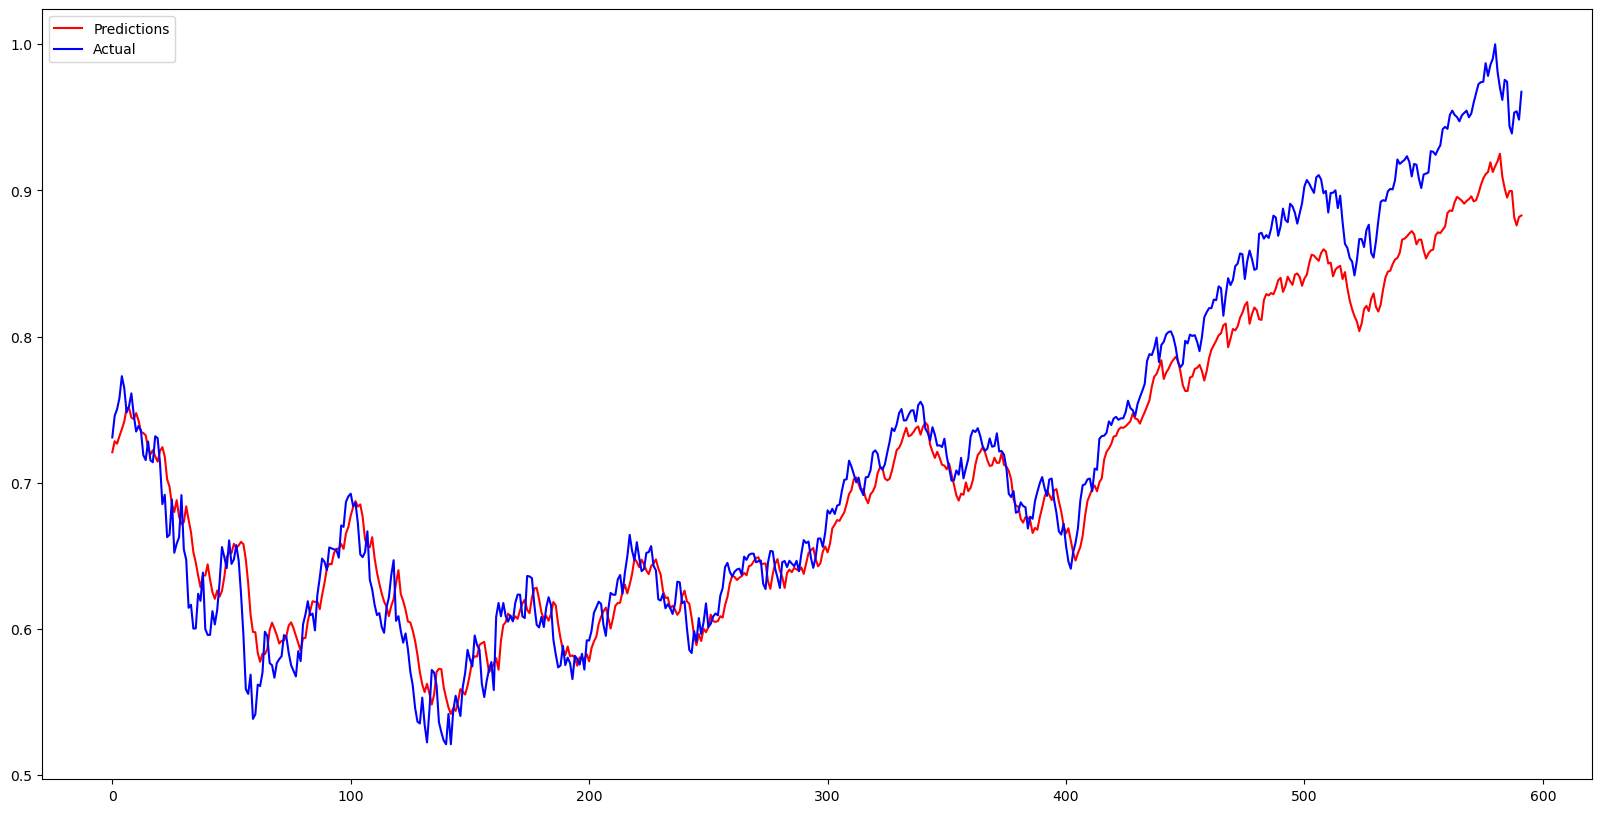

In [44]:
#Predictions
lstm_input = torch.from_numpy(X_test).float()
predictions = model(lstm_input).detach().numpy()

#Plot
plt.figure(figsize = (20,10))
plt.plot(predictions, color = 'red', label = 'Predictions')
plt.plot(y_test, color = 'blue', label = 'Actual')
plt.legend()
plt.show()


In [47]:
#Testing on a different index SPY, test the model's generalization

ndata = yf.download(tickers = 'SPY', start = '2010-08-01', end = '2024-08-01', interval = '1d')
ndata['RSI'] = ta.rsi(ndata['Close'], length = 15)
ndata['EMA20'] = ta.ema(ndata['Close'], length = 20)
ndata['EMA100'] = ta.ema(ndata['Close'], length = 100)
ndata['EMA150'] = ta.ema(ndata['Close'], length = 150)

#Prediction target: Closing price of the following day 
ndata['Target'] = ndata['Adj Close'].shift(-1) 

#Clean
ndata.dropna(inplace = True)
ndata.reset_index(inplace = True)
ndata.drop(columns = ['Volume', 'Close', 'Date'], axis = 1, inplace = True)

scaled_ndata = sc.fit_transform(ndata)

Xn = []
back_days = 10
for i in range(8):
    Xn.append([])
    for j in range(back_days, scaled_ndata.shape[0]):
        Xn[i].append(scaled_ndata[j-back_days:j, i])

Xn = np.array(Xn)
yn = np.reshape(np.array(scaled_ndata[back_days:, -1]), (Xn.shape[1], 1))
Xn = np.moveaxis(Xn, [0], [2])


[*********************100%%**********************]  1 of 1 completed


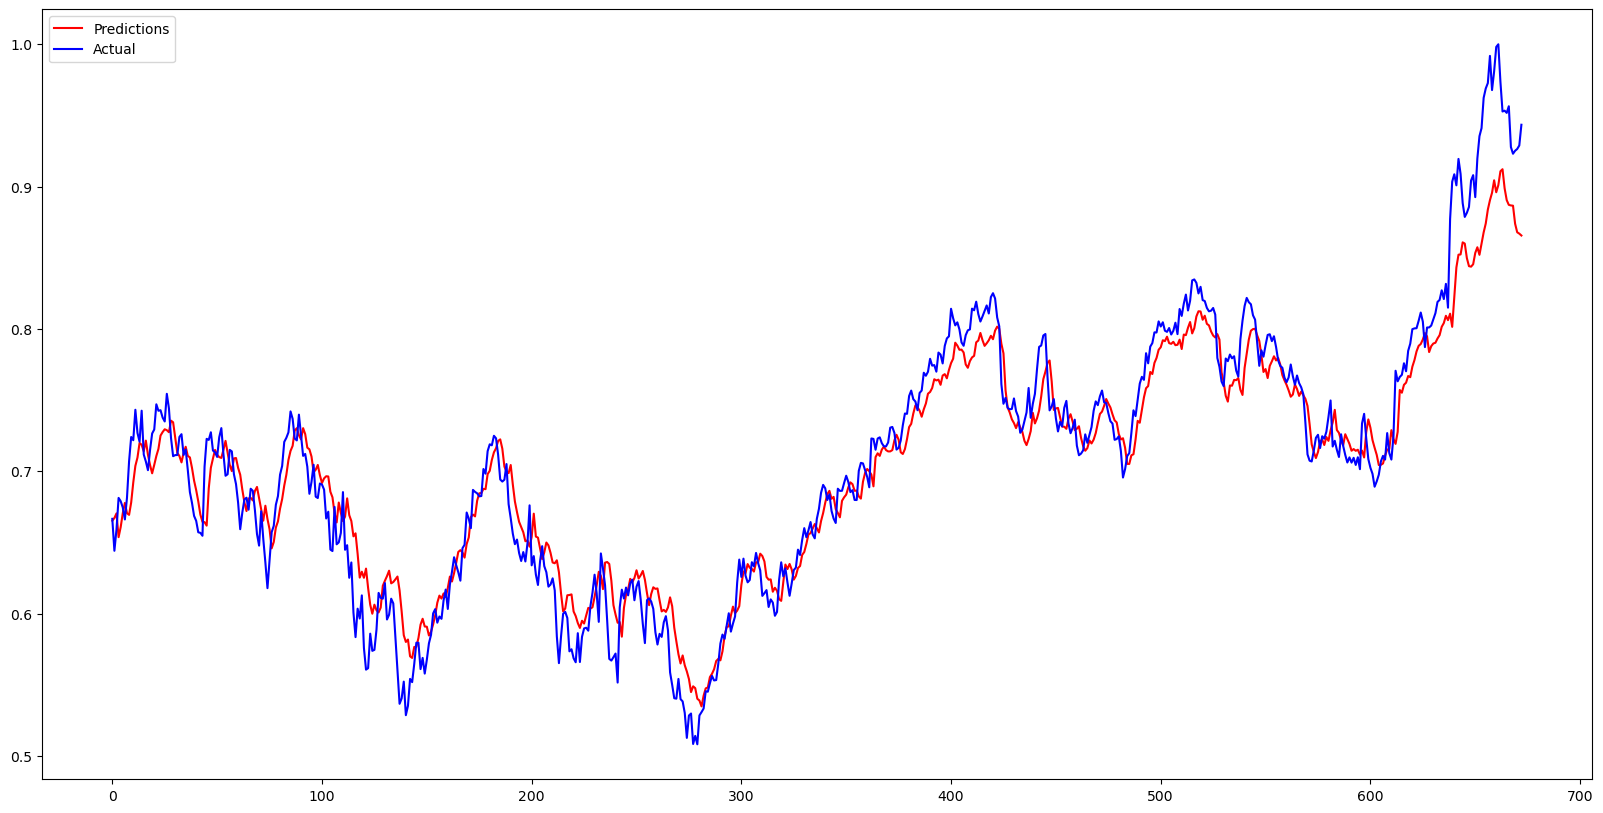

In [46]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size = 0.2, shuffle = False)
lstm_inputn = torch.from_numpy(Xn_test).float()
predictionsn = model(lstm_inputn).detach().numpy()

#Plot
plt.figure(figsize = (20,10))
plt.plot(predictionsn, color = 'red', label = 'Predictions')
plt.plot(yn_test, color = 'blue', label = 'Actual')
plt.legend()
plt.show()